# Vuelo 3 20190116 Pelicano

* [NeuralNetwork_cell](#NeuralNetwork_cell)
    * [NeuralNetwork p q_cell](#NeuralNetwork_pq_cell)
    * [Simulation_cell](#simulation_cell)


## Helicopter model
segun 5.2 Advance control for miniature helicopters: modelling, design and flight test

1. $ u^{(1)} = vr-wq-g \sin (\theta ) + X_u u$
2. $ v^{(1)} = wp-ur+ g \cos (\theta ) \sin (\phi ) + Y_v v$
3. $ w^{(1)} = uq - vp + g \cos(\theta) cos(\phi) + Z_w w + Z_{col} (\delta_{col} - \delta_{col0})$
4. $ p^{(1)} = -qr(I_{yy} - I_{zz})/I_{xx} + B_{lat}  (\delta_{lat} - \delta_{lat0})$
5. $ q^{(1)} = -pr(I_{zz} - I_{xx})/I_{yy} + A_{lon}  (\delta_{lon} - \delta_{lon0})$

Los parámetros a estimar son: 
1. $ X_u, Y_v, Z_w$
2. $B_{lat}, A_{lon}$
3. $\delta_{lat0}, \delta_{lon0}, \delta_{col0}$
4. $\phi_0, \theta_0$

No se analiza yaw (del rotor cola)!

## Discretizacion primer orden

Para el sistema $$ s x = \frac{1}{\tau}(-x + K u) =  $$
con $T_s$ tiempo entre muestras. 

El sistema discretizado es de la forma:
$$x[k+1] = x[k] + \frac{1}{\tau} T_s (-x[k] + K u[k])$$
$$x[k+1] =  ( 1 - \frac{T_s}{\tau}) x[k] +   \frac{K T_s}{\tau} u[k]$$

de la forma:
$$x[k+1] = a_0 x[k]  +   b_0 u[k]$$

con:
* $a_0 = 1 - \frac{T_s}{\tau} $
* $b_0 = \frac{K T_s}{\tau}$


y a la inversa:
* $ K = \frac {b_0}{1-a_0} $
* $ \tau = \frac{T_s}{1-a_0}$


## Discretizacion segundo orden

Para el sistema $$s^2 x + 2\zeta\omega sx + \omega^2 x = K \omega^2 u  $$
con $T_s$ tiempo entre muestras. 

El sistema discretizado es de la forma:
$$x[k+2] = a_1 x[k+1] + a_0 x[k] + b_0 u[k]$$

con:
* $a_1 = 2(1 - \zeta\omega T_s) $
* $a_0 = -1 +2\zeta\omega T_s - \omega^2 T_s^2$
* $b_0 = K \omega^2 T_s^2$


y a la inversa:
* $ \omega = \frac {\sqrt{1-a_0-a_1}}  {T_s}$
* $ \zeta = (1 - \frac{a_1}{2}) \frac{1}{\omega T_s}$
* $ K = \frac{b_0}{\omega^2 T_s^2}$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import curve_fit
from scipy import signal

In [2]:
# lee de los ficheros *.csv
data_fast = pd.read_csv('d:/20190116_pelicano_vuelos_paso_auto/vuelo3/datos/Fast_Telemetry_20190116_155416.csv', sep=';')
#data_slow = pd.read_csv('../../vuelo3/datos/Slow_Telemetry_20190116_155728.csv', sep=';')

In [3]:
data_fast.head(2)

,time,C001_X,C002_Y,C003_Z,C004_Roll,C005_Pitch,C006_Yaw,C007_vNorte,C008_vEste,C009_vAbajo,...,C130_CME_SERVO_7,C131_CME_RPM_REF,C132_CME_RPM_MED,C133_CME_RPM_SENS,C134_CME_RPM_RAW,C135_CME_P,C136_CME_I,C137_CME_D,C138_CME_T,C139_CME_T_MOD
0,17.195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1023,6100,0,0,0,1278,0,0,3799,6384
1,17.205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1023,6100,0,0,0,1278,0,0,3799,6384


In [4]:
# data_slow.head(2)

In [5]:
# imprime nombre de las columnas
#print('columnas --- fast')
if False:
    for k in data_fast.columns:
        print(k)

In [6]:
#print('columnas --- slow')
#for k in data_slow.columns:
#    print(k)    

Matriz de transformacion $R_b^i$


$$ [x^{(1)} y^{(1)}z^{(1)}]^T=R_b^i(\phi,\theta,\psi) [uvw]$$

con


$$ R_b^i(\phi,\theta,\psi) = \begin{bmatrix}
cos(\theta)cos(\psi) &  sin(\phi)sin(\theta)cos(\psi)-cos(\phi)sin(\psi) & cos(\phi)sin(\theta)cos(\psi)+sin(\phi)sin(\psi) \\
cos(\theta)sin(\psi) &  sin(\phi)sin(\theta)sin(\psi)+cos(\phi)cos(\psi) & cos(\phi)sin(\theta)sin(\psi)-sin(\phi)cos(\psi) \\
-sin(\theta)         &          sin(\phi)cos(\theta)&                                     cos(\phi)cos(\theta)
\end{bmatrix}$$

In [7]:
# matriz transformacion
# [x_dot y_dot z_dot]^T = R_b_i [u v w]^T
#
def get_R_b_i(phi, theta, psi):
    return [
        [np.cos(theta)*np.cos(psi),  np.sin(phi)*np.sin(theta)*np.cos(psi)-np.cos(phi)*np.sin(psi), np.cos(phi)*np.sin(theta)*np.cos(psi)+np.sin(phi)*np.sin(psi)],
        [np.cos(theta)*np.sin(psi),  np.sin(phi)*np.sin(theta)*np.sin(psi)+np.cos(phi)*np.cos(psi), np.cos(phi)*np.sin(theta)*np.sin(psi)-np.sin(phi)*np.cos(psi)],
        [-np.sin(theta),          np.sin(phi)*np.cos(theta),                                     np.cos(phi)*np.cos(theta)]]

In [8]:
# Inercias
Ixx = 163; #% [kg·m^2]
Ixx = 30; #% [kg·m^2] PRUEBAS

Iyy = 59; #% [kg·m^2]
Iyy = 90; #% [kg·m^2] PRUEBAS

Izz = 58; #% [kg·m^2]
Ixy = 0; #% [kg·m^2]
Iyx = 0; #% [kg·m^2]
Ixz = 59; #% [kg·m^2]

#------------------
Ixx = 23; #% [kg·m^2]
Iyy = 77; #% [kg·m^2]
Izz = 68; #% [kg·m^2]
Ixy = 0; #% [kg·m^2]
Iyx = 0; #% [kg·m^2]
Ixz = 0; #% [kg·m^2]

In [9]:
# determina rango valido de datos: n_ini, n_end
t_raw  = data_fast['time'].values 

n_ini = np.where(t_raw>1e8)
print(n_ini)
n_ini = n_ini[0][0]
print(n_ini)
time_0 = t_raw[n_ini]
print('time_0=', time_0)

print(time_0)

# actualiza t
t = t_raw[n_ini:] - time_0

(array([  1290,   1291,   1292, ..., 133918, 133919, 133920], dtype=int64),)
1290
time_0= 1547648958.6
1547648958.6


In [10]:
# tini
nini = n_ini

t_raw  = data_fast['time'][nini:].values - time_0

x_dot_raw =     data_fast['C007_vNorte'][nini:].values
y_dot_raw =     data_fast['C008_vEste'][nini:].values
z_dot_raw =     data_fast['C009_vAbajo'][nini:].values

d_col_raw = data_fast['c074_Collective'][nini:].values/1000.0
d_lon_raw = data_fast['C075_Lon_cyclic'][nini:].values/1000.0 - 1.0
d_lat_raw = data_fast['C076_Lat_cyclic'][nini:].values/1000.0 - 1.0
d_ped_raw = data_fast['C077_Tail'][nini:].values/1000.0 - 1.0

rpm = data_fast['C067_RotorRPM'][nini:].values

# salida estimador ?
p_raw = data_fast['C010_wRoll'][nini:].values
q_raw = data_fast['C011_wPitch'][nini:].values
r_raw = data_fast['C012_wYaw'][nini:].values

roll_raw = data_fast['C004_Roll'][nini:].values
pitch_raw = data_fast['C005_Pitch'][nini:].values
yaw_raw = data_fast['C006_Yaw'][nini:].values


# imu
p_raw = data_fast['C019_Wx_IMU'][nini:].values
q_raw = data_fast['C020_Wy_IMU'][nini:].values
r_raw = data_fast['C021_Wz_IMU'][nini:].values

az_raw = data_fast['C024_Az_IMU'][nini:].values

roll_raw = data_fast['C027_Roll_IMU'][nini:].values
pitch_raw = data_fast['C025_Pitch_IMU'][nini:].values
yaw_raw = data_fast['C026_Yaw_IMU'][nini:].values

# numero elementos
N = rpm.size

# fuerza Ts
Ts = 10E-3
# gravedad
g=9.81

In [11]:
# FILTRADO
Fs = 100
Fpwm = 15
b_f,a_f = signal.butter(3, (Fpwm/2)/(Fs/2))

x_dot_f     = signal.filtfilt(b_f,a_f,x_dot_raw)
y_dot_f     = signal.filtfilt(b_f,a_f,y_dot_raw)
z_dot_f     = signal.filtfilt(b_f,a_f,z_dot_raw)
p_f     = signal.filtfilt(b_f,a_f,p_raw)
q_f     = signal.filtfilt(b_f,a_f,q_raw)
r_f     = signal.filtfilt(b_f,a_f,r_raw)
d_col_f     = signal.filtfilt(b_f,a_f,d_col_raw)
d_lat_f     = signal.filtfilt(b_f,a_f,d_lat_raw)
d_lon_f     = signal.filtfilt(b_f,a_f,d_lon_raw)

az_f = signal.filtfilt(b_f,a_f,az_raw)

roll_f  = signal.filtfilt(b_f,a_f,roll_raw)
pitch_f  = signal.filtfilt(b_f,a_f,pitch_raw)
yaw_f  = signal.filtfilt(b_f,a_f,yaw_raw)

In [12]:
# generamos los vectores para u,v,w a partir de x_dot, y_dot, z_dot
Nd = yaw_f.size

u_f = np.zeros((Nd))
v_f = np.zeros((Nd))
w_f = np.zeros((Nd))

# inicialmente roll_0 = pitch_0 = 0
roll_0 = 0
pitch_0 = 0

##################################
n_ini = np.where(t_raw>735)[0][0]
n_end = np.where(t_raw>1150)[0][0]
##################################


roll_0  = roll_f[n_ini:n_end].mean()
pitch_0 = pitch_f[n_ini:n_end].mean()

# actualiza offset para roll y pitch
roll_f = roll_f - roll_0
pitch_f = pitch_f - pitch_0

In [13]:
for k in range(0,Nd):
    R_b_i = get_R_b_i(roll_f[k], pitch_f[k], yaw_f[k])
    # transpose
    R_b_i_T = np.transpose(R_b_i)
    uvw = np.matmul(R_b_i_T, np.array([[x_dot_f[k]],[y_dot_f[k]], [z_dot_f[k]]]))
    u_f[k] = uvw[0]
    v_f[k] = uvw[1]
    w_f[k] = uvw[2]

(400, 1200)

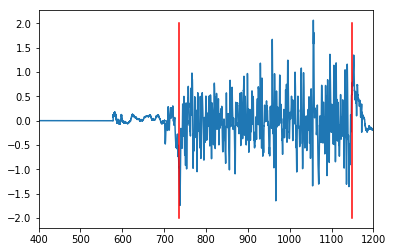

In [14]:
# region de interes

plt.plot(t,w_f)
plt.plot([t_raw[n_ini] ,t_raw[n_ini]],[-2, 2],'r')
plt.plot([t_raw[n_end] ,t_raw[n_end]],[-2, 2],'r')
plt.xlim(400,1200)

d_col_0 =  0.3635496335413298
d_lat_0 =  -0.38712466495009307
d_lon_0 =  0.3881451609567044


(735.0080001354218, 1150.0090000629425)

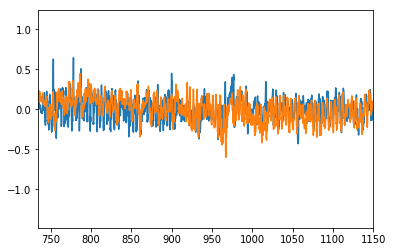

In [15]:
# eliminamos valores medios de los mandos (trimado)
d_col_0 = d_col_f[n_ini:n_end].mean()
d_lat_0 = d_lat_f[n_ini:n_end].mean()
d_lon_0 = d_lon_f[n_ini:n_end].mean()

print('d_col_0 = ',d_col_0)
print('d_lat_0 = ',d_lat_0)
print('d_lon_0 = ',d_lon_0)

# actualizamos los mandos
if True:
    d_col_f = d_col_f- d_col_0
    d_lat_f = d_lat_f- d_lat_0
    d_lon_f = d_lon_f- d_lon_0

# plt
plt.plot(t,d_lon_f)
plt.plot(t,d_lat_f)
plt.xlim(t[n_ini],t[n_end])

# Identificacion de parametros

In [19]:
# sistema segundo orden
def get_a1_a0_b0(sigma, omega, K, Ts):
    a_1 = 2*(1-sigma * omega * Ts)
    a_0 = -1 +2*sigma*omega*Ts - (omega*Ts)**2
    b_0 = K * (omega*Ts)**2
    return a_1, a_0, b_0

def get_sigma_omega_K(a_1, a_0, b_0, Ts):
    omega = np.sqrt(1-a_0-a_1)/Ts
    sigma = (1-a_1/2)*1/(omega*Ts)
    K = b_0/(omega*Ts)**2
    return sigma, omega, K

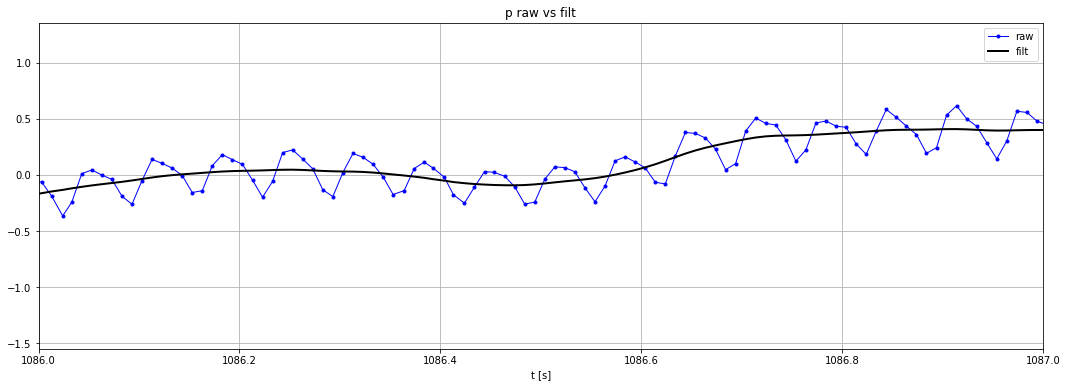

In [20]:
# visualiza filtrado 
plt.figure(figsize=(18,6))
plt.plot(t,p_raw,'.-b', label='raw', lw=1)
plt.plot(t,p_f, 'k', label='filt',lw=2)
#plt.xlim(t[108500],t[110000])
plt.xlim(1086,1086+1)
plt.legend()
plt.title('p raw vs filt' )
plt.xlabel('t [s]')
plt.grid()

# neural network
<a id='NeuralNetwork_cell'></a>

In [21]:
from sklearn.neural_network import MLPRegressor

## Identificacion p, q
<a id='NeuralNetwork_pq_cell'></a>

In [22]:
X = np.vstack((
    p_f[n_ini-1:n_end-1],
    p_f[n_ini-2:n_end-2],
    q_f[n_ini-1:n_end-1],
    q_f[n_ini-2:n_end-2],
    d_lon_f[n_ini:n_end],
    d_lat_f[n_ini:n_end])).T
y = np.vstack((
    p_f[n_ini:n_end],
    q_f[n_ini:n_end])).T
mlp = MLPRegressor(hidden_layer_sizes=(2),solver ='lbfgs', \
                   tol=1e-13, verbose=True, learning_rate='constant', activation='identity',max_iter=2000, shuffle=False, random_state=101)
mlp.fit(X,y)

print('n_iter_=', mlp.n_iter_ )
print('loss_=', mlp.loss_ )

n_iter_= 135
loss_= 1.261186456379458e-05


Text(0.5, 1.0, 'error')

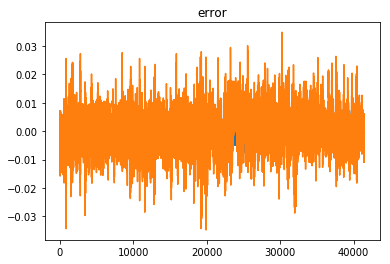

In [23]:
# error prediccion
y_pred = mlp.predict(X)
error = y-y_pred

plt.plot(error)
plt.title('error')

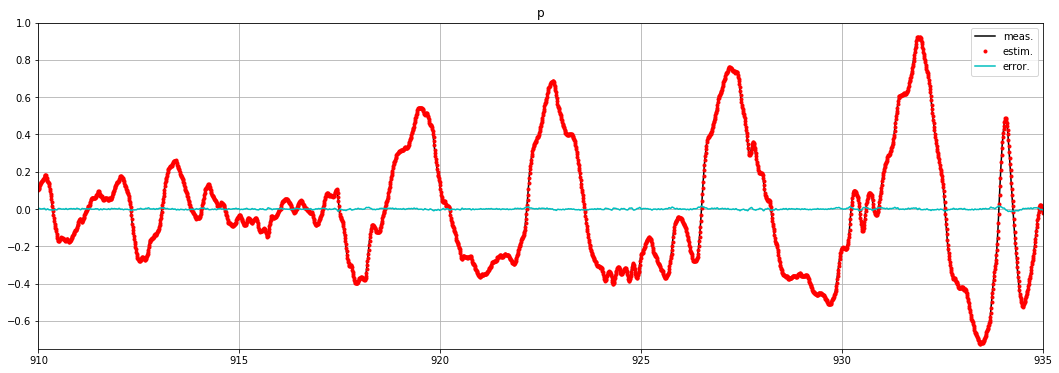

In [24]:
# ------------ p
plt.figure(figsize=(18,6))
plt.title('p')
plt.plot(t[n_ini:n_end],y[:,0],'-k', label='meas.')
plt.plot(t[n_ini:n_end],y_pred[:,0],'.r', label='estim.')
plt.plot(t[n_ini:n_end], error[:,0], 'c',label='error.')
plt.legend()
plt.xlim(910, 935)
plt.ylim(-0.75, 1)
plt.grid()

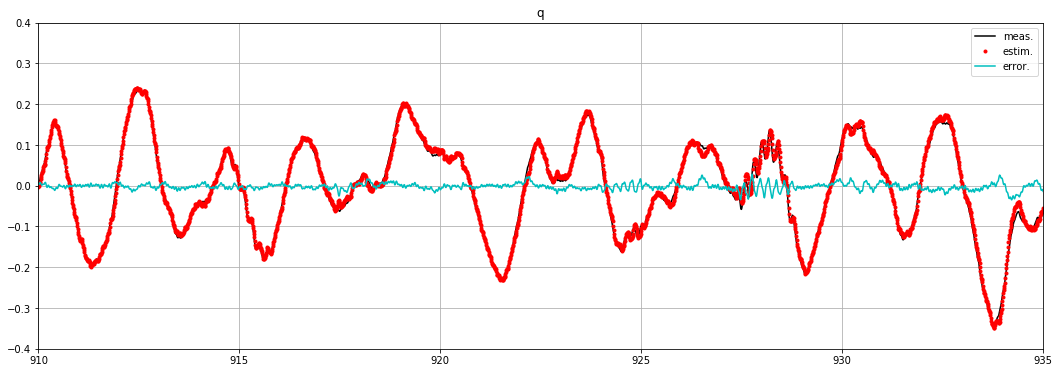

In [25]:
# ------------ q
plt.figure(figsize=(18,6))
plt.title('q')
plt.plot(t[n_ini:n_end],y[:,1],'-k', label='meas.')
plt.plot(t[n_ini:n_end],y_pred[:,1],'.r', label='estim.')
plt.plot(t[n_ini:n_end], error[:,1], 'c',label='error.')
plt.legend()
plt.xlim(910, 935)
plt.ylim(-0.4, .4)
plt.grid()

In [27]:
# parametros p

sol = mlp.predict([[0,0,0,0,1,0]])
k_p_lon = sol[0][0]
print('k_p_lon=',k_p_lon)

sol = mlp.predict([[0,0,0,0,0,1]])
k_p_lat = sol[0][0]
print('k_p_lat=',k_p_lat)

sol = mlp.predict([[1,0,0,0,0,0]])
k_p_p_1 = sol[0][0]
print('k_p_p_1=',k_p_p_1)

sol = mlp.predict([[0,1,0,0,0,0]])
k_p_p_2 = sol[0][0]
print('k_p_p_2=',k_p_p_2)

sol = mlp.predict([[0,0,1,0,0,0]])
k_p_q_1 = sol[0][0]
print('k_p_q_1=',k_p_q_1)

sol = mlp.predict([[0,0,0,1,0,0]])
k_p_q_2 = sol[0][0]
print('k_p_q_2=',k_p_q_2)

p_est = k_p_p_1 *p_f[n_ini-1:n_end-1] \
  + k_p_p_2*p_f[n_ini-2:n_end-2] \
  + k_p_q_1*q_f[n_ini-1:n_end-1] \
  + k_p_q_2*q_f[n_ini-2:n_end-2] \
  + k_p_lon*d_lon_f[n_ini:n_end] \
  + k_p_lat*d_lat_f[n_ini:n_end]

error = p_f[n_ini:n_end] - p_est

#plt.ylim(-0.02, 0.1)
print('-- p --')
sigma_p, omega_p, K_p = get_sigma_omega_K(k_p_p_1, k_p_p_0, k_p_lat, Ts)
print('{}= {:+.3f}'.format('sigma_p ', sigma_p))
print('{}= {:+.3f}'.format('omega_p ', omega_p))
print('{}= {:+.3f}'.format('K_p ', K_p))


k_p_lon= -0.005451590220066471
k_p_lat= 0.010270019155209309
k_p_p_1= 1.6000649499575583
k_p_p_2= -0.6024512171373023
k_p_q_1= -0.07838208574305183
k_p_q_2= 0.07218587842107016
-- p --
sigma_p = +4.094
omega_p = +4.885
K_p = +4.304


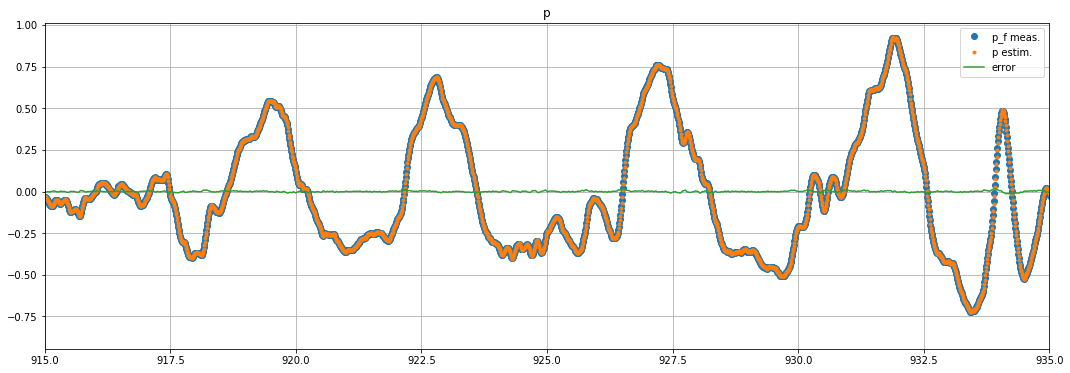

In [29]:
plt.figure(figsize=(18,6))
plt.title('p')
plt.plot(t[n_ini:n_end],p_f[n_ini:n_end],'o', label='p_f meas.')
plt.plot(t[n_ini:n_end], p_est,'.', label='p estim.')
plt.plot(t[n_ini:n_end], error, label='error')
plt.legend()
plt.xlim(915,935)
plt.grid()

In [31]:
# parametros q

sol = mlp.predict([[0,0,0,0,1,0]])
k_q_lon = sol[0][1]
print('k_q_lon=',k_q_lon)

sol = mlp.predict([[0,0,0,0,0,1]])
k_q_lat = sol[0][1]
print('k_q_lat=',k_q_lat)

sol = mlp.predict([[1,0,0,0,0,0]])
k_q_p_1 = sol[0][1]
print('k_q_p_1=',k_q_p_1)

sol = mlp.predict([[0,1,0,0,0,0]])
k_q_p_2 = sol[0][1]
print('k_q_p_2=',k_q_p_2)

sol = mlp.predict([[0,0,1,0,0,0]])
k_q_q_1 = sol[0][1]
print('k_q_q_1=',k_q_q_1)

sol = mlp.predict([[0,0,0,1,0,0]])
k_q_q_2 = sol[0][1]
print('k_q_q_2=',k_q_q_2)

q_est = k_q_p_1 *p_f[n_ini-1:n_end-1] \
  + k_q_p_2*p_f[n_ini-2:n_end-2] \
  + k_q_q_1*q_f[n_ini-1:n_end-1] \
  + k_q_q_2*q_f[n_ini-2:n_end-2] \
  + k_q_lon*d_lon_f[n_ini:n_end] \
  + k_q_lat*d_lat_f[n_ini:n_end]

error = q_f[n_ini:n_end] - q_est

#plt.ylim(-0.02, 0.1)
print('-- q --')
sigma_q, omega_q, K_q = get_sigma_omega_K(k_q_q_1, k_q_q_2, k_p_lon, Ts)
print('{}= {:+.3f}'.format('sigma_p ', sigma_q))
print('{}= {:+.3f}'.format('omega_p ', omega_q))
print('{}= {:+.3f}'.format('K_p ', K_q))


k_q_lon= -0.044121937586326876
k_q_lat= 0.02039078555368723
k_q_p_1= -0.8467286717357565
k_q_p_2= 0.8527516798792674
k_q_q_1= 0.49424047246691166
k_q_q_2= 0.48747950040347793
-- q --
sigma_p = +5.568
omega_p = +13.520
K_p = -0.298


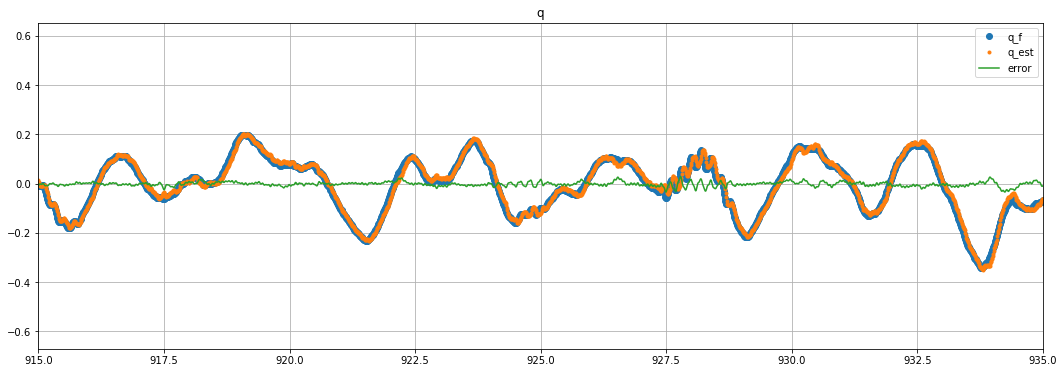

In [32]:
plt.figure(figsize=(18,6))
plt.title('q')
plt.plot(t[n_ini+2:n_end+2],q_f[n_ini+2:n_end+2],'o', label='q_f')
plt.plot(t[n_ini+2:n_end+2], q_est,'.', label='q_est')
plt.plot(t[n_ini+2:n_end+2], error, label='error')
plt.legend()
plt.xlim(915,935)
plt.grid()

# simulacion
<a id='simulation_cell'></a>

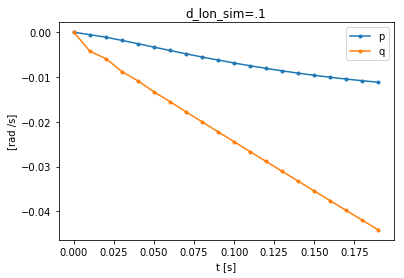

In [35]:
N =20
t_sim = np.arange(0,N)*Ts

phi_sim = np.zeros(N)
theta_sim = np.zeros(N)
p_sim = np.zeros(N)
q_sim = np.zeros(N)
d_lat_sim = np.zeros(N)
d_lon_sim = np.zeros(N)

for k in range(1,N):
    if k<10:
        d_lon_sim[k]=.1
        d_lat_sim[k]=0
    elif k<20:
        d_lon_sim[k]=.1
        d_lat_sim[k]=0
    else:
        d_lon_sim[k]=.1
        d_lat_sim[k]=0
        
    X = [[p_sim[k-1], p_sim[k-2], q_sim[k-1], q_sim[k-2], d_lon_sim[k], d_lat_sim[k]]]
    y = mlp.predict(X)
    p_sim[k] = y[0][0]
    q_sim[k] = y[0][1]
    phi_sim[k] = phi_sim[k-1] + Ts*p_sim[k]
    theta_sim[k] = theta_sim[k-1] + Ts*q_sim[k]

plt.figure()
plt.title('d_lon_sim=.1')
plt.plot(t_sim,p_sim, '.-', label='p')    
plt.plot(t_sim,q_sim, '.-', label='q')    
plt.xlabel('t [s]')
plt.ylabel('[rad /s]')
#plt.ylim(-.05,.05)
plt.legend()


Text(0, 0.5, '[rad /s/s]')

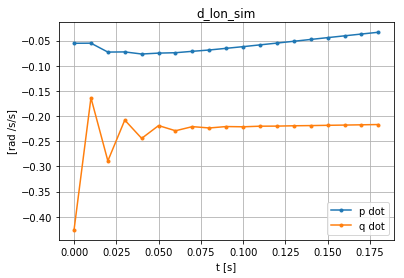

In [36]:
plt.title('d_lon_sim')
plt.plot(t_sim[0:-1], np.diff(p_sim)/Ts,'.-', label='p dot')
plt.plot(t_sim[0:-1], np.diff(q_sim)/Ts,'.-', label='q dot')
plt.legend()
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('[rad /s/s]')

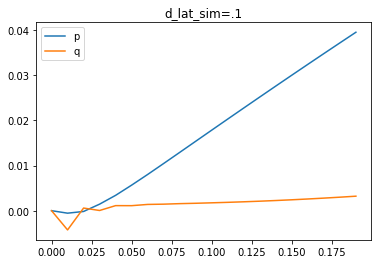

In [37]:
for k in range(0,N-2):
    if k<100:
        d_lon_sim[k]=0
        d_lat_sim[k]=.1
    elif k<20:
        d_lon_sim[k]=0
        d_lat_sim[k]=.1
    else:
        d_lon_sim[k]=0
        d_lat_sim[k]=.1

    X = [[p_sim[k+1], p_sim[k], q_sim[k], q_sim[k+1], d_lon_sim[k], d_lat_sim[k]]]
    y = mlp.predict(X)
    p_sim[k+2] = y[0][0]
    q_sim[k+2] = y[0][1]
    phi_sim[k+1] = phi_sim[k] + Ts*p_sim[k]
    theta_sim[k+1] = theta_sim[k] + Ts*q_sim[k]

    
plt.figure()
plt.title('d_lat_sim=.1')

plt.plot(t_sim, p_sim, label='p')    
plt.plot(t_sim, q_sim, label='q')    
#plt.ylim(-.05,.05)
plt.legend()


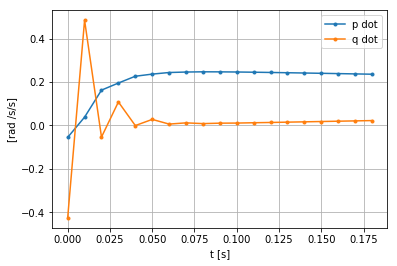

In [38]:
plt.plot(t_sim[0:-1], np.diff(p_sim)/Ts,'.-', label='p dot')
plt.plot(t_sim[0:-1], np.diff(q_sim)/Ts,'.-', label='q dot')
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('[rad /s/s]')
plt.grid()
